# Lab04-1: Perceptron, Adaline, and Optimization

---

Implement the Adaline with SGD which can set different batch_size (M) as parameter. Then, use the Iris dataset to fit your model with 3 different (including) and fixed learning rate and print out the accuracy of each model. Last, plot the cost against the number of epochs using different in one figure.

## 1. Preprocessing: Split training and testing data & Standardization

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from IPython.display import display

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


## 2. Handcrafted Adaline classifier with M as parameter.

In [2]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    minibatch: int    
        Minibatch of size M

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.
        
    """
    def __init__(self, minibatch=1, eta=0.01, n_iter=50, shuffle=True, random_state=1):
        self.minibatch = minibatch
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : np.random.seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for bi in range(X.shape[0] // self.minibatch):
                start = bi * self.minibatch
                end = start + self.minibatch 
                cost.append(self._update_weights(X[start:end], y[start:end]))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, Xb, yb):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(Xb)
        
        # Cost function
        error = (yb - output)
        cost = 0.5 * np.sum(error ** 2)
        
        # Update rule
        self.w_[1:] += self.eta * Xb.T.dot(error)
        self.w_[0] += self.eta * error.sum()
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

## 3. Fit model with 3 different M and fixed η. (including M=1)

In [3]:
from sklearn.metrics import accuracy_score

# Print the accuracy of each model
def acc_AdalineSGD(minibatch):
    adas = AdalineSGD(minibatch=minibatch, n_iter=20, eta=0.01, random_state=1)
    adas.fit(X_train_std, y_train)

    # Testing accuracy
    y_pred = adas.predict(X_test_std)
    print(f'Minibatch={minibatch}')
    print('Misclassified samples: %d' % (y_test != y_pred).sum())
    print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))
    
    return adas

adas_m1 = acc_AdalineSGD(minibatch=1)
adas_m2 = acc_AdalineSGD(minibatch=10)
adas_m3 = acc_AdalineSGD(minibatch=30)

Minibatch=1
Misclassified samples: 3
Accuracy: 0.85

Minibatch=10
Misclassified samples: 3
Accuracy: 0.85

Minibatch=30
Misclassified samples: 3
Accuracy: 0.85



## 4. Plot the cost against the number of epochs using different M in one figure.

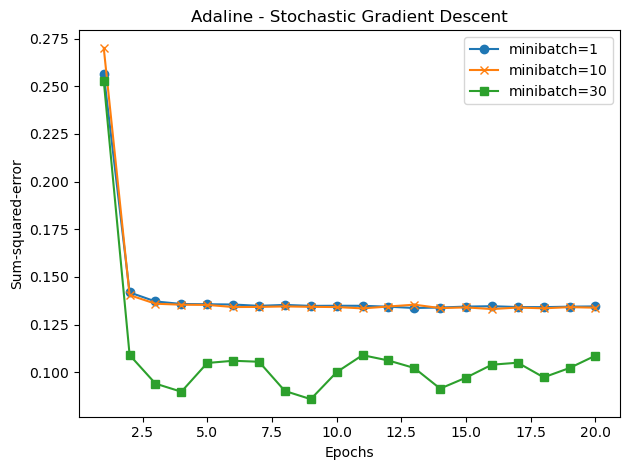

In [4]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(adas_m1.cost_) + 1), adas_m1.cost_,
         marker='o', label=f'minibatch={adas_m1.minibatch}')
plt.plot(range(1, len(adas_m2.cost_) + 1), adas_m2.cost_,
         marker='x', label=f'minibatch={adas_m2.minibatch}')
plt.plot(range(1, len(adas_m3.cost_) + 1), adas_m3.cost_,
         marker='s', label=f'minibatch={adas_m3.minibatch}')

plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('./Lab04-1_110062619.png', dpi=300)
plt.show()